In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [75]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])
roi_names = ['V1', 'V2', 'V3', 'V3AB', 'hV4', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'LO1', 'LO2']
n_rois = 11
n_subj = 7

#### Load CCGP

In [60]:
fn2load = os.path.join(root, 'Analysis', 'decoding_results', 'ccgp.npy')
ccgp = np.load(fn2load, allow_pickle=True).item()
ccgp.keys()

dict_keys(['acc_ccgp', 'c_value', 'roi_names'])

In [61]:
si = 4; # only S5 done so far

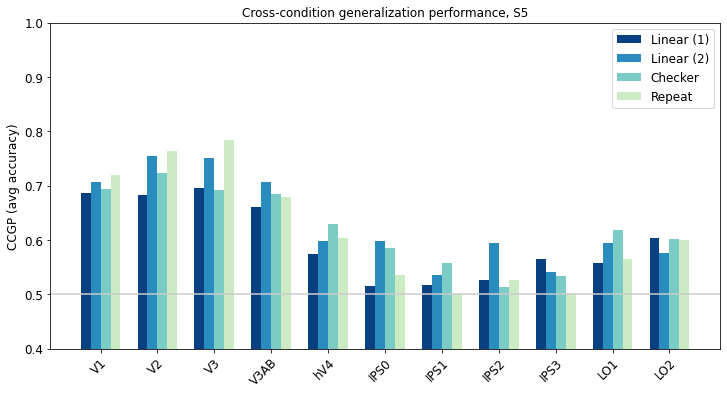

In [71]:
# choosing just S5 here, for comparability

vals = np.mean(dec['acc_ccgp'][si:si+1,:,:,:], axis=3)

meanvals = np.mean(vals, axis=0)
# semvals = np.std(vals, axis=0)/np.sqrt(n_subj-1)
semvals = np.full(np.shape(meanvals), np.nan)

plot_utils.plot_multi_bars(mean_data = meanvals, \
                           err_data = semvals, \
                           # point_data = vals, \
                           # add_ss_lines=False,
                           colors = task_colors, \
                           space = 0.15, \
                           title = 'Cross-condition generalization performance, S5', \
                           ylim = [0.40, 1.0], \
                           horizontal_line_pos = 0.50,
                           xticklabels = roi_names, \
                           ylabel = 'CCGP (avg accuracy)', \
                           legend_overlaid=True, \
                           legend_separate=False, \
                           legend_labels = np.array(task_names));

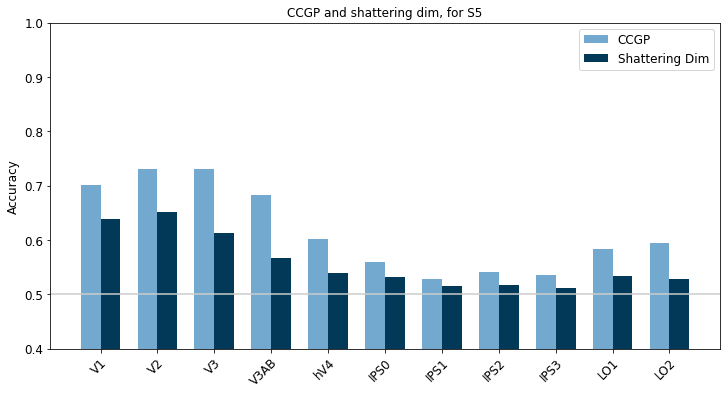

In [65]:
# choosing just S5 here, for comparability

vals1 = np.mean(np.mean(dec['acc_ccgp'][si:si+1,:,:,:], axis=3), axis=2, keepdims=True)
vals2 = np.mean(np.mean(dim['acc_each_dichotomy'][:,:,:,:], axis=3), axis=2, keepdims=True)

vals = np.concatenate([vals1, vals2], axis=2)

meanvals = np.mean(vals, axis=0)
# semvals = np.std(vals, axis=0)/np.sqrt(n_subj-1)
semvals = np.full(np.shape(meanvals), np.nan)

plot_utils.plot_multi_bars(mean_data = meanvals, \
                           err_data = semvals, \
                           # point_data = vals, \
                           # add_ss_lines=False,
                           colors = cm.PuBu(np.linspace(0,1,5))[[2,4],:], \
                           space = 0.15, \
                           title = 'CCGP and shattering dim, for S5', \
                           ylim = [0.40, 1.0], \
                           horizontal_line_pos = 0.50,
                           xticklabels = roi_names, \
                           ylabel = 'Accuracy', \
                           legend_overlaid=True, \
                           legend_separate=False, \
                           legend_labels = ['CCGP','Shattering Dim']);

#### Load shattering dim

In [82]:
subjects = [1,2,5,6]
n_subjects = len(subjects)
n_rois = 11; n_tasks = 4; n_dich = 6435
acc_each_dichotomy = np.zeros((n_subjects, n_rois, n_tasks, n_dich))
    
for si, ss in enumerate(subjects):
    fn2load = os.path.join(root, 'Analysis', 'decoding_results', 'S%02d_shattering_dim.npy'%ss)
    dim = np.load(fn2load, allow_pickle=True).item()
    
    acc_each_dichotomy[si,:,:,:] = dim['acc_each_dichotomy']

In [81]:
dim['acc_each_dichotomy'].shape

(11, 4, 6435)

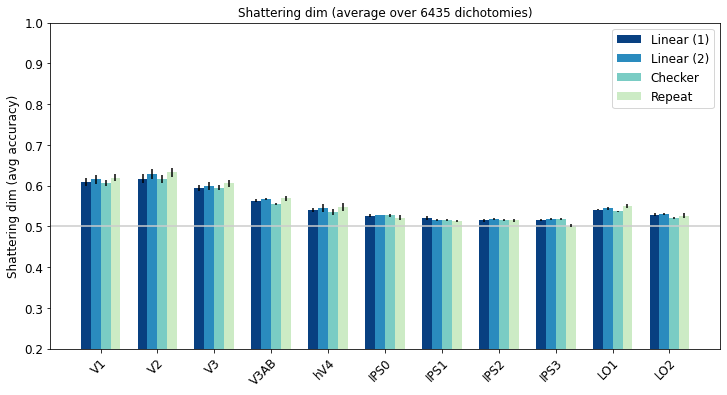

In [83]:
plot_utils.set_all_font_sizes(12)

vals = np.mean(acc_each_dichotomy, axis=3)

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj-1)
# semvals = np.full(np.shape(meanvals), np.nan)

plot_utils.plot_multi_bars(mean_data = meanvals, \
                           err_data = semvals, \
                           # point_data = vals, \
                           # add_ss_lines=False,
                           colors = task_colors, \
                           space = 0.15, \
                           title = 'Shattering dim (average over %d dichotomies)'%n_dich, \
                           ylim = [0.2, 1.0], \
                           horizontal_line_pos = 0.50,
                           xticklabels = roi_names, \
                           ylabel = 'Shattering dim (avg accuracy)', \
                           legend_overlaid=True, \
                           legend_separate=False, \
                           legend_labels = np.array(task_names));

In [126]:
thresh_values = np.linspace(0.40, 1.0, 100)
n_thresh = len(thresh_values)

dim_values = np.zeros((n_subjects, n_rois, n_tasks, n_thresh))

for si in range(n_subjects):
    for ri in range(n_rois):
        for ti in range(n_tasks):

            vals = acc_each_dichotomy[si,ri,ti,:]

            # compute dimensionality of representations, for each threshold value
            for xx, thresh in enumerate(thresh_values):

                n_above_chance = np.sum(vals>thresh)

                if n_above_chance==0:
                    d  = 0
                else:
                    # d = log2(Nc)
                    d = np.log2(n_above_chance)

                dim_values[si, ri, ti, xx] = d


In [114]:
np.log2(n_dich)

12.651724433108065

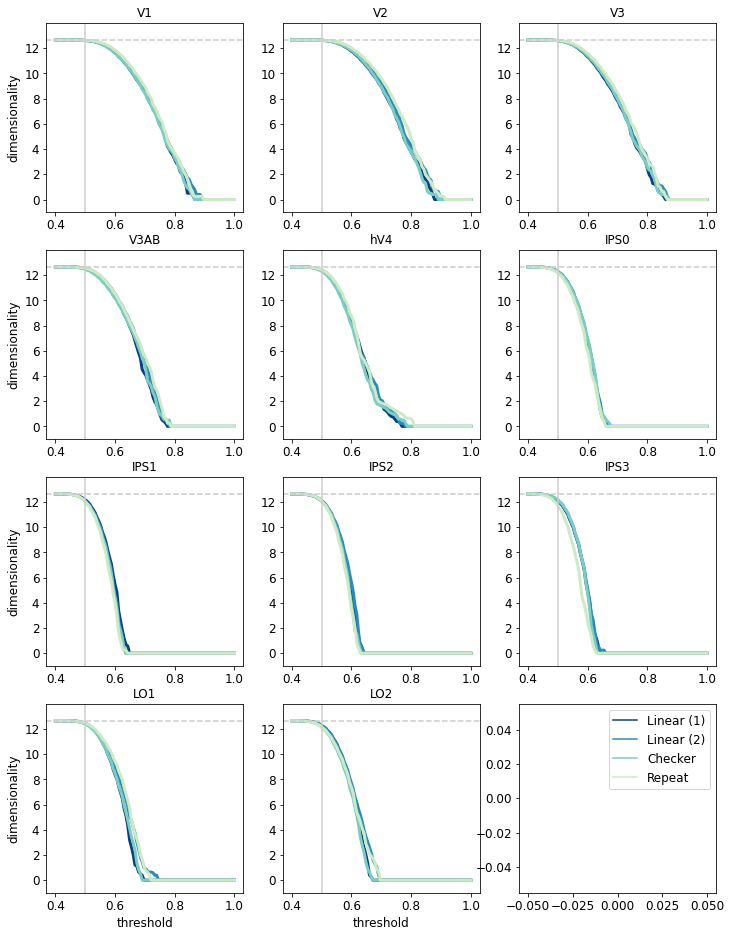

In [121]:
plt.figure(figsize=(12, 16))

for ri in range(n_rois):
    
    plt.subplot(4,3,ri+1)

    for ti in range(n_tasks):

        d = dim_values[:, ri, ti, :]
        meanvals = np.mean(d, axis=0)

        plt.plot(thresh_values, meanvals, color=task_colors[ti,:], lw = 3)
        
    plt.axvline(0.5, color=[0.8, 0.8, 0.8])

    plt.ylim([-1, 14])
    plt.yticks(np.arange(0,12.1,2))
    plt.title(roi_names[ri])
    if ri>=9:
        plt.xlabel('threshold')
    if np.mod(ri,3)==0:
        plt.ylabel('dimensionality')
        
    plt.axhline(np.log2(n_dich), linestyle='--', color=[0.8, 0.8, 0.8])
plt.subplot(4,3,12)
for ti in range(n_tasks):
    plt.plot(0,0,color=task_colors[ti,:])
plt.legend(task_names)

0.7515151515151515

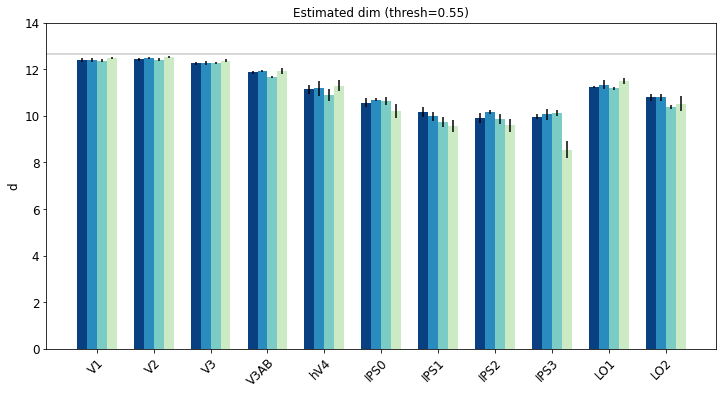

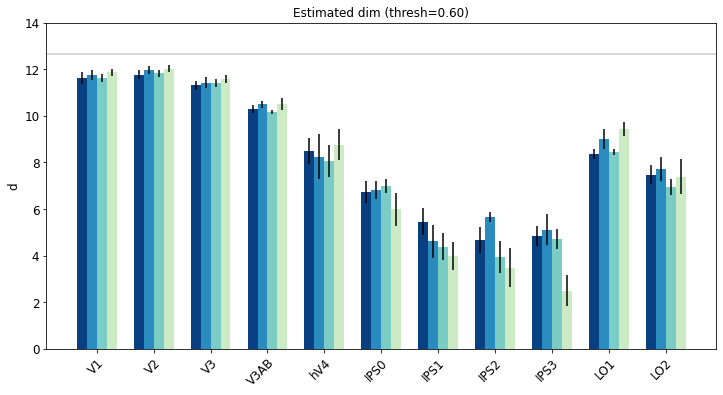

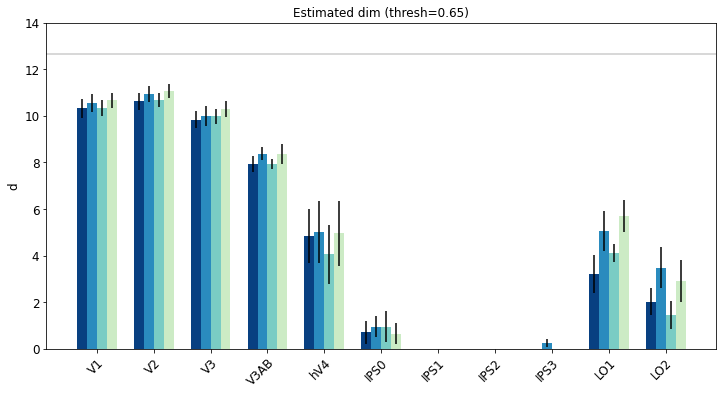

In [134]:
for thresh in [0.55, 0.60, 0.65]:

    xi = np.argmin(np.abs(thresh_values-thresh))

    plot_utils.set_all_font_sizes(12)

    vals = dim_values[:,:,:,xi]

    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subj-1)
    # semvals = np.full(np.shape(meanvals), np.nan)

    plot_utils.plot_multi_bars(mean_data = meanvals, \
                               err_data = semvals, \
                               # point_data = vals, \
                               # add_ss_lines=False,
                               colors = task_colors, \
                               space = 0.15, \
                               title = 'Estimated dim (thresh=%.2f)'%thresh, \
                               ylim = [0, 14], \
                               horizontal_line_pos = np.log2(n_dich), \
                               xticklabels = roi_names, \
                               ylabel = 'd', \
                               legend_overlaid=False, \
                               legend_separate=False, \
                               legend_labels = np.array(task_names));